In [ ]:
!pip install wheel setuptools pip --upgrade
!pip install swig
!pip install gymnasium[box2d]
!pip install wandb

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import torch
import numpy as np
import os
import random
from torch import nn
import torch.nn.functional as F
from gym.wrappers.monitoring.video_recorder import VideoRecorder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
class PPO(nn.Module):
    def __init__(self, n_inputs, n_actions, hidden_dim):
        super(PPO, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(n_inputs, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions),
            nn.Softmax(dim=1),
        )
        self.critic = nn.Sequential(
            nn.Linear(n_inputs, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

In [ ]:
model = PPO(8,8,4)
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
|  actor.0.weight |     32     |
|   actor.0.bias  |     4      |
|  actor.2.weight |    256     |
|   actor.2.bias  |     64     |
|  actor.4.weight |    512     |
|   actor.4.bias  |     8      |
| critic.0.weight |     32     |
|  critic.0.bias  |     4      |
| critic.2.weight |    256     |
|  critic.2.bias  |     64     |
| critic.4.weight |     64     |
|  critic.4.bias  |     1      |
+-----------------+------------+
Total Trainable Params: 1297


1297

In [ ]:
class Memory:
    def __init__(self):
        self.observations:list = []
        self.actions:list = []
        self.rewards:list = []
        self.terminated:list = []
        self.old_logprob:list = []
    def clear(self):
        del self.observations[:]
        del self.actions[:]
        del self.rewards[:]
        del self.terminated[:]
        del self.old_logprob[:]
    def append(self, observation, action, reward, terminated):
        self.observations.append(observation)
        self.actions.append(action)
        self.rewards.append(reward)
        self.terminated.append(terminated)
    def append_logprob(self, old_logprob):
        self.old_logprob.append(old_logprob)

    def Observation(self):
        return torch.tensor(np.array(self.observations), dtype=torch.float32).to(device)
    def Action(self):
        return torch.tensor(self.actions, dtype=torch.int64).to(device)
    def Reward(self):
        return torch.tensor(self.rewards, dtype=torch.float32).to(device)
    def Terminated(self):
        return torch.tensor(self.terminated, dtype=torch.float32).to(device)
    def Old_logprob(self):
        return torch.tensor(self.old_logprob, dtype=torch.float32).to(device)

In [ ]:
class Agent:
    def __init__(self, device, gamma=0.99, episilon=0.2, alpha=1, beta=0.01):
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.net = PPO(8, 4, 128).to(device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        self.memory = Memory()
        self.episilon = episilon

    def sampling(self, observation: torch.Tensor) -> torch.Tensor:
        prob = self.net.actor(observation)
        dist = torch.distributions.Categorical(prob)
        action = dist.sample()
        logprob = dist.log_prob(action).squeeze()
        self.memory.append_logprob(logprob)
        return action.item()

    def update(self, n_epoch=5):
        def normalize(x: torch.Tensor, episilon=1e-5) -> torch.Tensor:
            return (x - x.mean())/(x.std()+episilon)

        def discount(self, rewards: torch.Tensor, terminated: torch.Tensor) -> torch.Tensor:
            discount_reward = []
            r_tmp = 0
            for i in range(rewards.shape[0]-1, -1, -1):
                if terminated[i] == 1:
                    r_tmp = 0
                r_tmp = rewards[i] + self.gamma * r_tmp
                discount_reward.insert(0, r_tmp)
            return torch.stack(discount_reward)

        discount_reward = discount(self, self.memory.Reward(), self.memory.Terminated())
        discount_reward = normalize(discount_reward)
        old_logprob = self.memory.Old_logprob()

        mean_loss = 0
        for epoch in range(n_epoch):
            value = self.net.critic(self.memory.Observation()).squeeze()
            probalities = self.net.actor(self.memory.Observation())
            dist = torch.distributions.Categorical(probalities)
            logprob = dist.log_prob(self.memory.Action()).squeeze()

            advantage = discount_reward - value
            advantage = normalize(advantage)
            ratio = torch.exp(logprob - old_logprob.detach())

            actor_loss = -torch.min(ratio * advantage, torch.clamp(ratio, 1-self.episilon, 1+self.episilon) * advantage)
            crictic_loss = nn.MSELoss()(value, discount_reward)
            entropy_loss = -torch.mean(dist.entropy())
            loss = actor_loss + self.alpha*crictic_loss + self.beta*entropy_loss
            loss = loss.mean()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            mean_loss += loss.item()

            print("\rEpoch: {}, Loss: {}".format(epoch, loss.item()), end="")

        self.memory.clear()
        return mean_loss/n_epoch

    def save(self, model_name):
        torch.save(self.net.state_dict(), model_name)


In [ ]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")
agent = Agent(device)
Num_episode = 200
episode_length = 1000
reward_per_eps = []
loss_per_eps = []
total_reward_per_eps = []
for episode in range(Num_episode):
    print("\nEpisode: {}".format(episode))
    total_reward = 0
    rounds = 1
    observation, info = env.reset()
    for t in range(episode_length):
        action = agent.sampling(torch.tensor(observation)[None,:].to(device))
        new_observation, reward, terminated, truncated, info = env.step(action)
        agent.memory.append(observation, action, reward, terminated)
        total_reward += reward
        observation = new_observation
        if terminated:
            observation, info = env.reset()
            rounds += 1

    loss = agent.update()
    loss_per_eps.append(loss)
    total_reward_per_eps.append(total_reward)

    reward_per_eps.append(total_reward/rounds)

    print("\nEpisode: {}, Mean_Loss: {} Mean_Reward: {}, Rounds: {}".format(episode+1, loss,  total_reward/rounds, rounds))
    agent.save("lunar_lander_model.pth")

env.close()


Episode: 0
Epoch: 4, Loss: 0.9179605841636658
Episode: 1, Mean_Loss: 0.966870391368866 Mean_Reward: -220.3972002376477, Rounds: 12

Episode: 1
Epoch: 4, Loss: 0.8951058983802795
Episode: 2, Mean_Loss: 0.9186222791671753 Mean_Reward: -223.9790334499453, Rounds: 10

Episode: 2
Epoch: 4, Loss: 1.069094181060791
Episode: 3, Mean_Loss: 1.1021966457366943 Mean_Reward: -184.28600773785956, Rounds: 10

Episode: 3
Epoch: 4, Loss: 0.9769063591957092
Episode: 4, Mean_Loss: 0.9841704726219177 Mean_Reward: -217.44578999515338, Rounds: 9

Episode: 4
Epoch: 4, Loss: 0.9860538244247437
Episode: 5, Mean_Loss: 1.0165308237075805 Mean_Reward: -180.06616516196044, Rounds: 10

Episode: 5
Epoch: 4, Loss: 0.9661071300506592
Episode: 6, Mean_Loss: 0.9760926842689515 Mean_Reward: -120.89659342113586, Rounds: 10

Episode: 6
Epoch: 4, Loss: 0.9041287899017334
Episode: 7, Mean_Loss: 0.9167984604835511 Mean_Reward: -203.95436519459, Rounds: 10

Episode: 7
Epoch: 4, Loss: 0.8992592692375183
Episode: 8, Mean_Loss: 

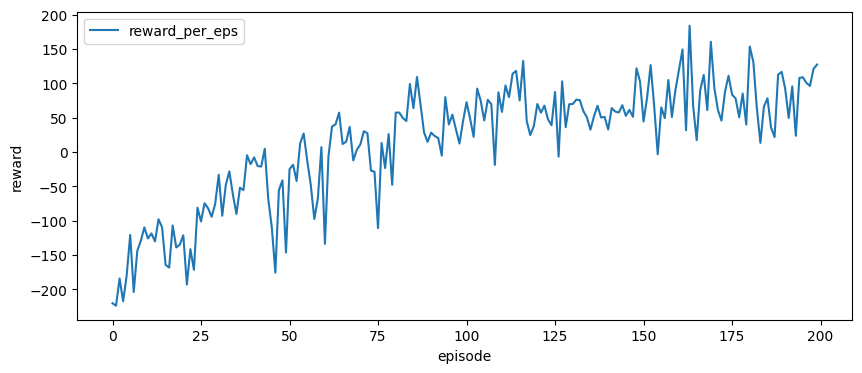

<Figure size 640x480 with 0 Axes>

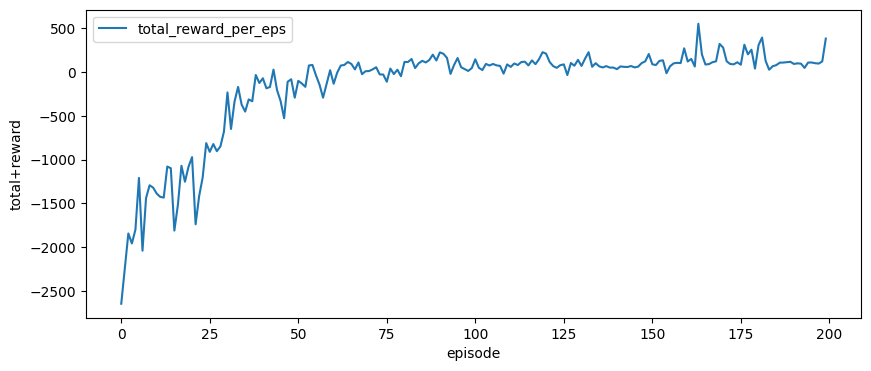

<Figure size 640x480 with 0 Axes>

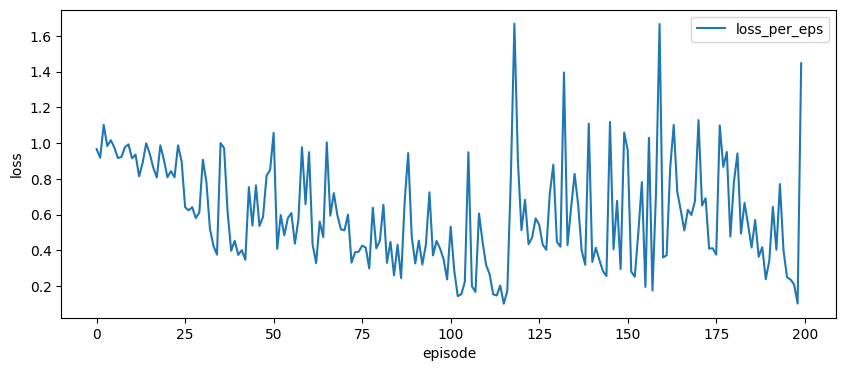

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,4))
plt.plot(reward_per_eps, label = "reward_per_eps")
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()
plt.show()
plt.savefig('reward.png')

plt.figure(figsize=(10,4))
plt.plot(total_reward_per_eps, label = "total_reward_per_eps")
plt.xlabel('episode')
plt.ylabel('total+reward')
plt.legend()
plt.show()
plt.savefig('total_reward.png')

plt.figure(figsize=(10,4))
plt.plot(loss_per_eps, label = "loss_per_eps")
plt.xlabel('episode')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.savefig('loss.png')

In [ ]:
env = gym.make("LunarLander-v2", render_mode='rgb_array')
vid = VideoRecorder(env, path="video/LunarLander-v2_learned.mp4")
observation = env.reset()[0]

agent = Agent(device)
agent.net.load_state_dict(torch.load('lunar_lander_model.pth'))
total_reward = 0
done = False
while not done:
    frame = env.render()
    vid.capture_frame()
    action = agent.sampling(torch.tensor(observation)[None,:].to(device))
    observation, reward, done, info, _ = env.step(action)
    total_reward += reward
vid.close()
env.close()
print(f"\nTotal reward: {total_reward}")


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [ ]:
env = gym.make("LunarLander-v2", render_mode='human')
observation, info = env.reset()
agent = Agent(device)
agent.net.load_state_dict(torch.load('lunar_lander_model.pth'))
for t in range(1000):
    action = agent.sampling(torch.tensor(observation)[None,:].to(device))
    new_observation, reward, terminated, truncated, info = env.step(action)
    agent.memory.append(observation, action, reward, terminated)
    total_reward += reward
    observation = new_observation
    if terminated or truncated:
        observation, info = env.reset()
        print (total_reward)
        total_reward = 0

239.70252045420932
